In [1]:
from typing import List
from Model.Betting.bet import Bet

def get_minutes_until_race_start(bet: Bet) -> float:
    minutes_diff = (bet.bet_offer.event_datetime - bet.bet_offer.race_card.datetime).seconds / 60
    
    if bet.bet_offer.event_datetime < bet.bet_offer.race_card.datetime:
        minutes_diff *= -1
    return minutes_diff

def plot_test_bets_return(test_bets: List[Bet], axis, label: str) -> None:
    payout_values = [bet.payout for bet in test_bets]
    date_values = [bet.bet_offer.event_datetime for bet in test_bets]
    cum_payout_values = cumsum(payout_values)
    sns.lineplot(ax=axis, x=date_values, y=cum_payout_values, label=label)
    
def get_wealth_snapshots(test_bets: List[Bet], kelly_fraction: float) -> List[float]:
    payout_values = [bet.payout for bet in test_bets]
    wealth = 1
    wealth_snapshots = []
    
    for payout in payout_values:
        wealth *= (1 + kelly_fraction * payout)
        wealth_snapshots.append(wealth)
        
    return wealth_snapshots
    

def plot_wealth_snapshots(axis, test_bets: List[Bet], label: str) -> None:
    possible_kelly_fraction = [i / 10 for i in range(11)]
    best_wealth_snapshots = [0.0]
    best_kelly_fraction = 0
    
    for kelly_fraction in possible_kelly_fraction:
        wealth_snapshots = get_wealth_snapshots(test_bets, kelly_fraction)
        wealth_snapshots = [log(wealth_snapshot) for wealth_snapshot in wealth_snapshots]
        
        if wealth_snapshots[-1] > best_wealth_snapshots[-1]:
            best_wealth_snapshots = wealth_snapshots
            best_kelly_fraction = kelly_fraction
            
    date_values = [bet.bet_offer.event_datetime for bet in test_bets]
    label = f"{label} (\u03B1 = {best_kelly_fraction})"
    sns.lineplot(ax=axis, x=date_values, y=best_wealth_snapshots, label=label)

-----------------------------------
Race: 6254051
Offer: Odds for Wath Court: 70.0
Stakes: 0.09727557470423583
Payout: 6.541782398859859
-----------------------------------

0.11017163792274674
0.0021104361956858944
52.203254544229814
-----------------------------------
Race: 6248442
Offer: Odds for Ank Marvin: 22.0
Stakes: 0.007367281965577222
Payout: -0.007367281965577222
-----------------------------------

0.0524869509671419
0.0010040820382602358
52.27356826149941
-----------------------------------
Race: 6004602
Offer: Odds for Gaazooo: 28.0
Stakes: 0.023421777969431647
Payout: -0.023421777969431647
-----------------------------------

0.058299571613380514
0.00110973619326168
52.53462216279474
-----------------------------------
Race: 6139740
Offer: Odds for Looksee: 34.0
Stakes: 0.04494194691011812
Payout: 1.4448835931602977
-----------------------------------

0.07303188964805583
0.0013834300836576118
52.790444931607155
-----------------------------------
Race: 6029855
Offer: Od

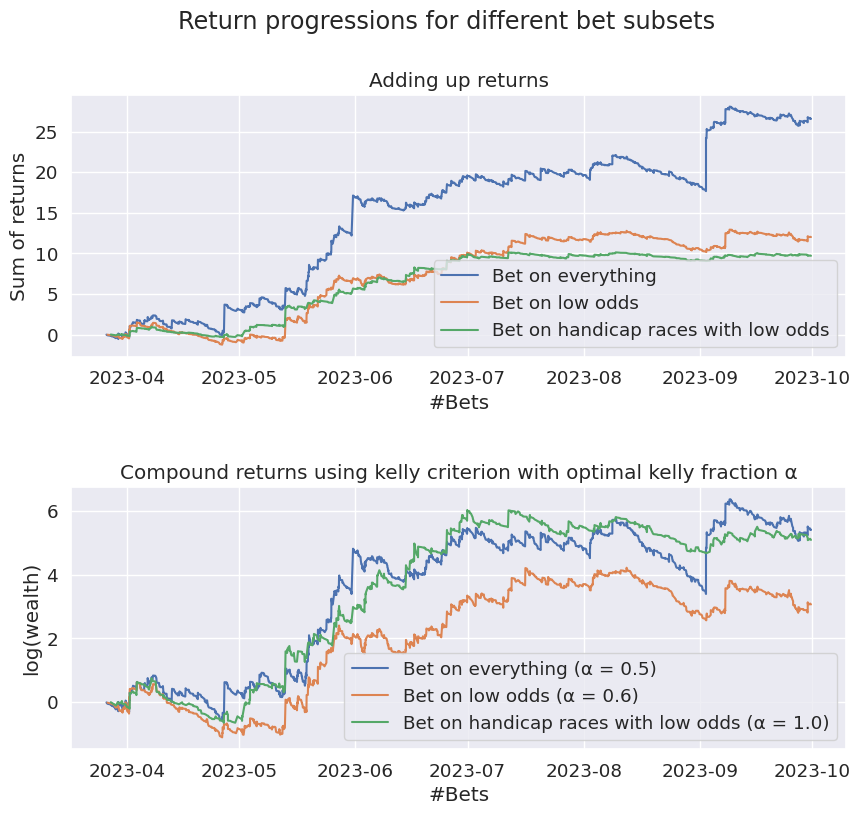

In [2]:
from Model.Betting.bet import Bet
from typing import List
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import cumsum, log

sns.set(rc={'figure.figsize':(10,8.5)}, font_scale=1.2)

TEST_BETS_PATH = "../data/test_payouts.dat"

with open(TEST_BETS_PATH, "rb") as f:
    test_bets_base = pickle.load(f)
    
test_bets_base = [bet for bet in test_bets_base if bet.payout < 30]
test_bets_base = sorted(test_bets_base, key=lambda bet: bet.bet_offer.event_datetime)

bet = test_bets_base[0]

sorted_bets = [bet for bet in test_bets_base if bet.probability_start > 0]
sorted_bets = sorted(sorted_bets, key=lambda bet: bet.probability_estimate / bet.probability_start)

worst_bets = sorted_bets[-30:]

for bet in worst_bets:
    print(bet)
    print(bet.probability_estimate)
    print(bet.probability_start)
    print(bet.probability_estimate / bet.probability_start)

fig, axes = plt.subplots(2, 1)
fig.suptitle('Return progressions for different bet subsets')

test_bets_base = [bet for bet in test_bets_base if bet.probability_start > -1]# and bet.bet_offer.race_card.category == "HCP"]

axes[0].set_title("Adding up returns")
axes[0].set(xlabel="#Bets", ylabel="Sum of returns")
plot_test_bets_return(test_bets=test_bets_base, axis=axes[0], label="Bet on everything")

test_bets_low_odds = [bet for bet in test_bets_base if bet.bet_offer.odds < 20]

axes[0].set(xlabel="#Bets", ylabel="Sum of returns")
plot_test_bets_return(test_bets=test_bets_low_odds, axis=axes[0], label="Bet on low odds")

test_bets_low_handicap = [bet for bet in test_bets_base if bet.bet_offer.race_card.category == "HCP" and bet.bet_offer.odds < 20]

axes[0].set(xlabel="#Bets", ylabel="Sum of returns")
plot_test_bets_return(test_bets=test_bets_low_handicap, axis=axes[0], label="Bet on handicap races with low odds")


axes[1].set_title(f"Compound returns using kelly criterion with optimal kelly fraction \u03B1")
axes[1].set(xlabel="#Bets", ylabel="log(wealth)")
plot_wealth_snapshots(axis=axes[1], test_bets=test_bets_base, label="Bet on everything")

axes[1].set(xlabel="#Bets", ylabel="log(wealth)")
plot_wealth_snapshots(axis=axes[1], test_bets=test_bets_low_odds, label="Bet on low odds")

axes[1].set(xlabel="#Bets", ylabel="log(wealth)")
plot_wealth_snapshots(axis=axes[1], test_bets=test_bets_low_handicap, label="Bet on handicap races with low odds")

plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

In [78]:
from random import shuffle

for _ in range(10):
    shuffle(test_bets_low_handicap)
    wealth_snapshots = get_wealth_snapshots(test_bets_low_handicap, kelly_fraction=1.0)
    min_wealth = min(wealth_snapshots)
    print(min_wealth)

0.4108522176507404
0.8150738383240151
0.34200148019114146
1.114326208632778
0.566321891851565
0.7422651069774104
0.9661241923939493
0.6989660348734557
0.7041714867825142
0.679105093566347


## Displaying payouts per race category

{'NOV': 0.9950981517996931, 'HCP': 1.005694453662179, 'MDN': 1.0001079769634358, 'CON': 0.9853932522103943, 'CST': 1.0363450674027572, 'JUV': 1.0596400139152544, 'LST': 1.0010611006916352, 'GD1': 0.9861535085646306, 'GD2': 1.044613973968808, 'GR3': 0.9926643984861049, 'TRL': 1.062092828147779, 'GR2': 1.0278251113930428, 'GR1': 1.0365025893030617, 'CLM': 0.987797129145787, '': 0.9953753181072222}
{'NOV': 830, 'HCP': 1559, 'MDN': 672, 'CON': 173, 'CST': 29, 'JUV': 10, 'LST': 95, 'GD1': 15, 'GD2': 12, 'GR3': 49, 'TRL': 7, 'GR2': 38, 'GR1': 48, 'CLM': 12, '': 12}


(0.95, 1.1)

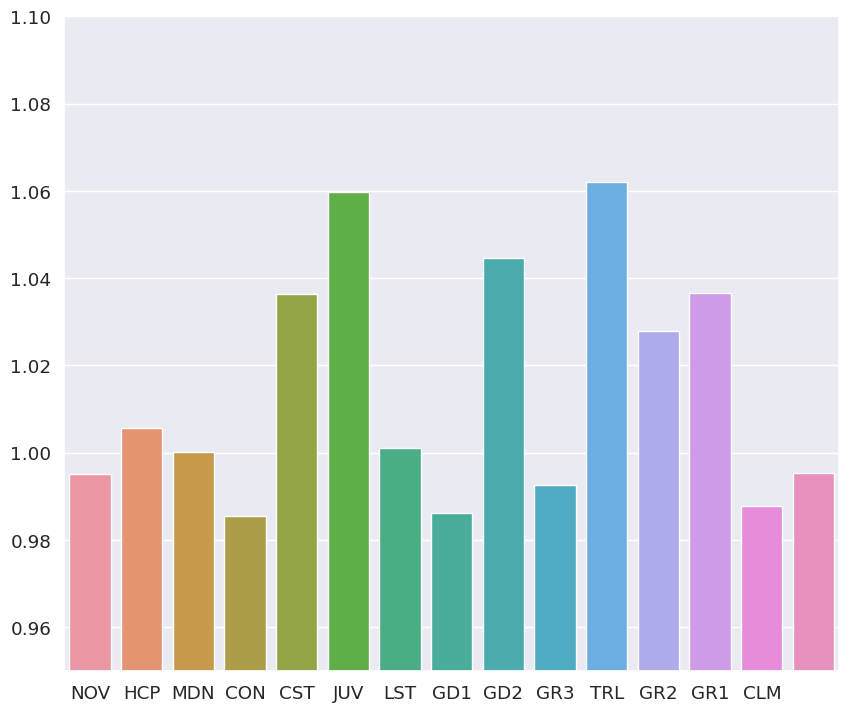

In [77]:
from statistics import geometric_mean
from Model.Betting.bet import Bet
from typing import List
import numpy as np

def get_payouts_per_category(bets: List[Bet], category: str):
    payouts = {}
    
    for bet in bets:
        cat = bet.bet_offer.race_card.__getattribute__(category)
        if cat not in payouts:
            payouts[cat] = []
            
        payouts[cat].append(1 + bet.payout)
        
    return payouts
    
payouts_per_category = get_payouts_per_category(test_bets_base, "category")

payout_means = {}
payout_counts = {}

for race_category in payouts_per_category:
    payout_means[race_category] = geometric_mean(payouts_per_category[race_category])
    payout_counts[race_category] = len(payouts_per_category[race_category])

print(payout_means)
print(payout_counts)
sns.barplot(x=list(payout_means.keys()), y=list(payout_means.values()))
plt.ylim(0.95, 1.1)

In [131]:
import numpy as np

estimated_value = [bet.bet_offer.odds * bet.probability_estimate for bet in test_bets_base]
payouts = [bet.payout for bet in test_bets_base]

np.corrcoef(estimated_value, payouts)
# sns.scatterplot(x=estimated_value, y=payouts)
# plt.xlim(-1400, 100)

array([[1.        , 0.04906291],
       [0.04906291, 1.        ]])

{'low': -0.5555020151518922, 'mid': 3.9871980528803332, 'high': 0.0}
{'low': 122, 'mid': 35, 'high': 0}


<AxesSubplot:>

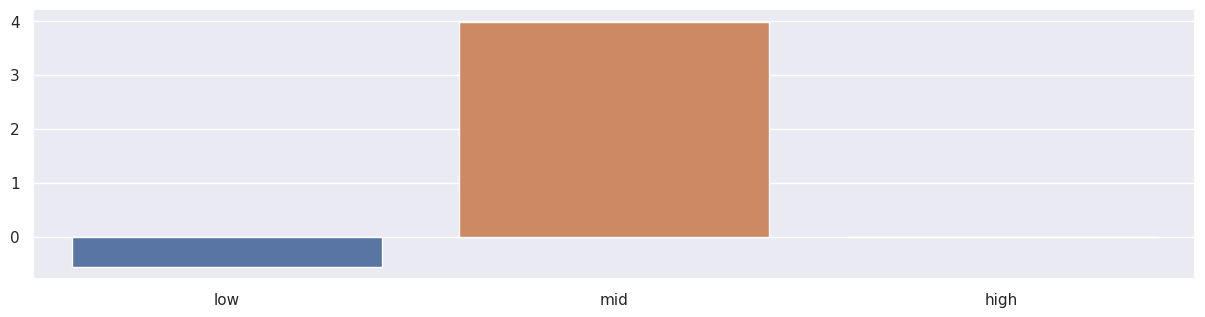

In [39]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets_low_handicap:
    odds = bet.bet_offer.odds
    
    odds_category = "low"
    if 5 <= odds <= 20:
        odds_category = "mid"
    if 20 < odds:
        odds_category = "high"
        
    payouts[odds_category].append(bet.payout)

payout_sums = {"low": 0, "mid": 0, "high": 0}
payout_counts = {"low": 0, "mid": 0, "high": 0}

for odds_category in payouts:
    payout_sums[odds_category] = np.sum(payouts[odds_category])
    payout_counts[odds_category] = len(payouts[odds_category])
    
print(payout_sums)
print(payout_counts)
    
sns.barplot(x=list(payout_sums.keys()), y=list(payout_sums.values()))

{'low': nan, 'mid': 0.008465064353021483, 'high': 0.021857936546041026}
{'low': 0, 'mid': 1528, 'high': 157}


/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/PycharmProjects/WageringSystem/venv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<AxesSubplot:>

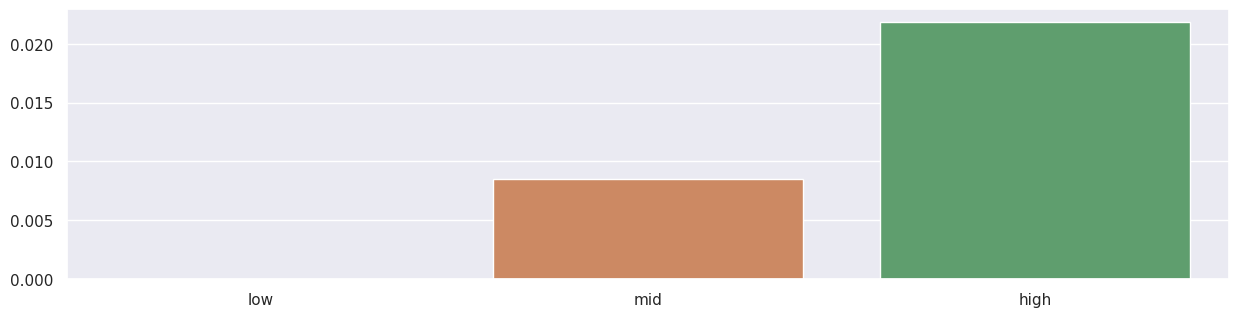

In [40]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets_low_odds:
    prob_estimate = bet.probability_estimate

    prob_estimate_category = "low"
    if 0.05 <= prob_estimate <= 0.25:
        prob_estimate_category = "mid"
    if 0.25 < prob_estimate:
        prob_estimate_category = "high"

    payouts[prob_estimate_category].append(bet.payout)

prob_estimate_sums = {"low": 0, "mid": 0, "high": 0}
prob_estimate_counts = {"low": 0, "mid": 0, "high": 0}

for prob_estimate_category in payouts:
    prob_estimate_sums[prob_estimate_category] = np.mean(payouts[prob_estimate_category])
    prob_estimate_counts[prob_estimate_category] = len(payouts[prob_estimate_category])

print(prob_estimate_sums)
print(prob_estimate_counts)

sns.barplot(x=list(prob_estimate_sums.keys()), y=list(prob_estimate_sums.values()))

{'low': 0.00957767739946189, 'mid': 0.007058793106622996, 'high': 0.019223152987948567}
{'low': 1563, 'mid': 78, 'high': 44}


<AxesSubplot:>

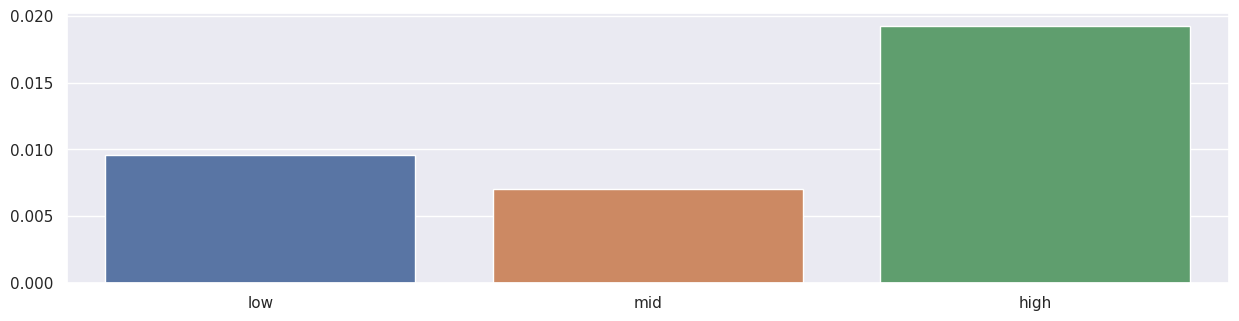

In [41]:
import numpy as np

payouts = {"low": [], "mid": [], "high": []}

for bet in test_bets_low_odds:
    prob_estimate = bet.bet_offer.adjustment_factor

    prob_estimate_category = "low"
    if 0.7 <= prob_estimate <= 0.9:
        prob_estimate_category = "mid"
    if prob_estimate < 0.7:
        prob_estimate_category = "high"

    payouts[prob_estimate_category].append(bet.payout)

prob_estimate_sums = {"low": 0, "mid": 0, "high": 0}
prob_estimate_counts = {"low": 0, "mid": 0, "high": 0}

for prob_estimate_category in payouts:
    prob_estimate_sums[prob_estimate_category] = np.mean(payouts[prob_estimate_category])
    prob_estimate_counts[prob_estimate_category] = len(payouts[prob_estimate_category])

print(prob_estimate_sums)
print(prob_estimate_counts)

sns.barplot(x=list(prob_estimate_sums.keys()), y=list(prob_estimate_sums.values()))

<AxesSubplot:ylabel='Count'>

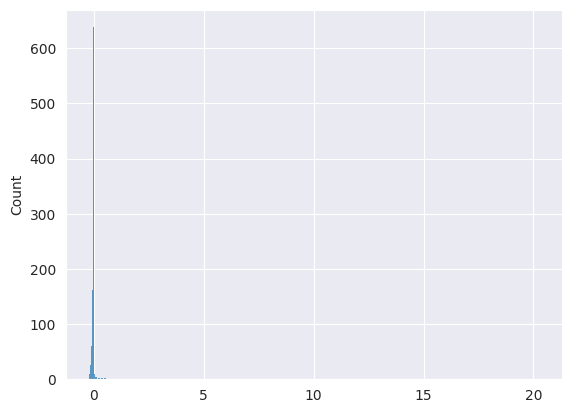

In [38]:
sns.histplot(payouts["mid"])

In [2]:
import sys
sys.path.append('/home/daniel/PycharmProjects/WageringSystem')

from Experiments.FundHistorySummary import FundHistorySummary
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def show_summary_grid(fund_history_summary: FundHistorySummary) -> None:
    sns.set(rc={'figure.figsize':(26,15)})
    f, axes = plt.subplots(2, 1)

    start_wealth = 1000
    bet_limit_fraction = 0.5
    show_fixed_betting_wealth_progression(axes[0], fund_history_summary, start_wealth=start_wealth, betting_limit=1000)
    show_dynamic_betting_wealth_progression(axes[1], fund_history_summary, start_wealth=start_wealth, bet_limit_fraction=bet_limit_fraction)

def show_fixed_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, betting_limit: float):
    snapshots = fund_history_summary.snapshots
    dates = [snapshot.date.split()[0] for snapshot in snapshots]
    absolute_payouts = [snapshot.payout_percentages * betting_limit for snapshot in snapshots]
    wealth_progression = [start_wealth + payout_sum for payout_sum in cumsum(absolute_payouts)]

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is: {betting_limit}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

def show_dynamic_betting_wealth_progression(axis, fund_history_summary: FundHistorySummary, start_wealth: float, bet_limit_fraction: float) -> None:
    dates = [snapshot.date.split()[0] for snapshot in fund_history_summary.snapshots]

    current_wealth = start_wealth
    wealth_progression = []
    for i in range(len(fund_history_summary.snapshots)):
        betting_limit = current_wealth * bet_limit_fraction
        current_wealth += fund_history_summary.snapshots[i].payout_percentages * betting_limit
        wealth_progression.append(current_wealth)

    sns.lineplot(x=dates, y=wealth_progression, ax=axis)

    max_date = datetime.strptime(max(dates), '%Y-%m-%d')
    min_date = datetime.strptime(min(dates), '%Y-%m-%d')
    summary_day_interval = (max_date - min_date).days
    axis.xaxis.set_major_locator(mdates.DayLocator(interval=int(summary_day_interval / 5)))

    axis.set_title(f"Wealth progression over unseen test races. Betting limit is current wealth multiplied by {bet_limit_fraction:.2f}")
    axis.set_xlabel(f"Date")
    axis.set_ylabel(f"Current Wealth")

<AxesSubplot:>

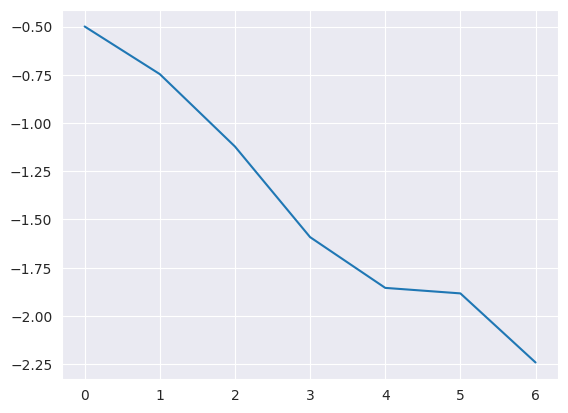

bet rate: 0.4521651560926485
max losses: 0.4877224369010293
min:-0.40205780052305334
max:0.8104727595202854
avg:-0.0006941577404636012
mid count: 446
high count: 404
low count: 48
{'mid': -1.3173410192776493, 'high': -0.6234185520626283, 'low': 0.5621622987795668}


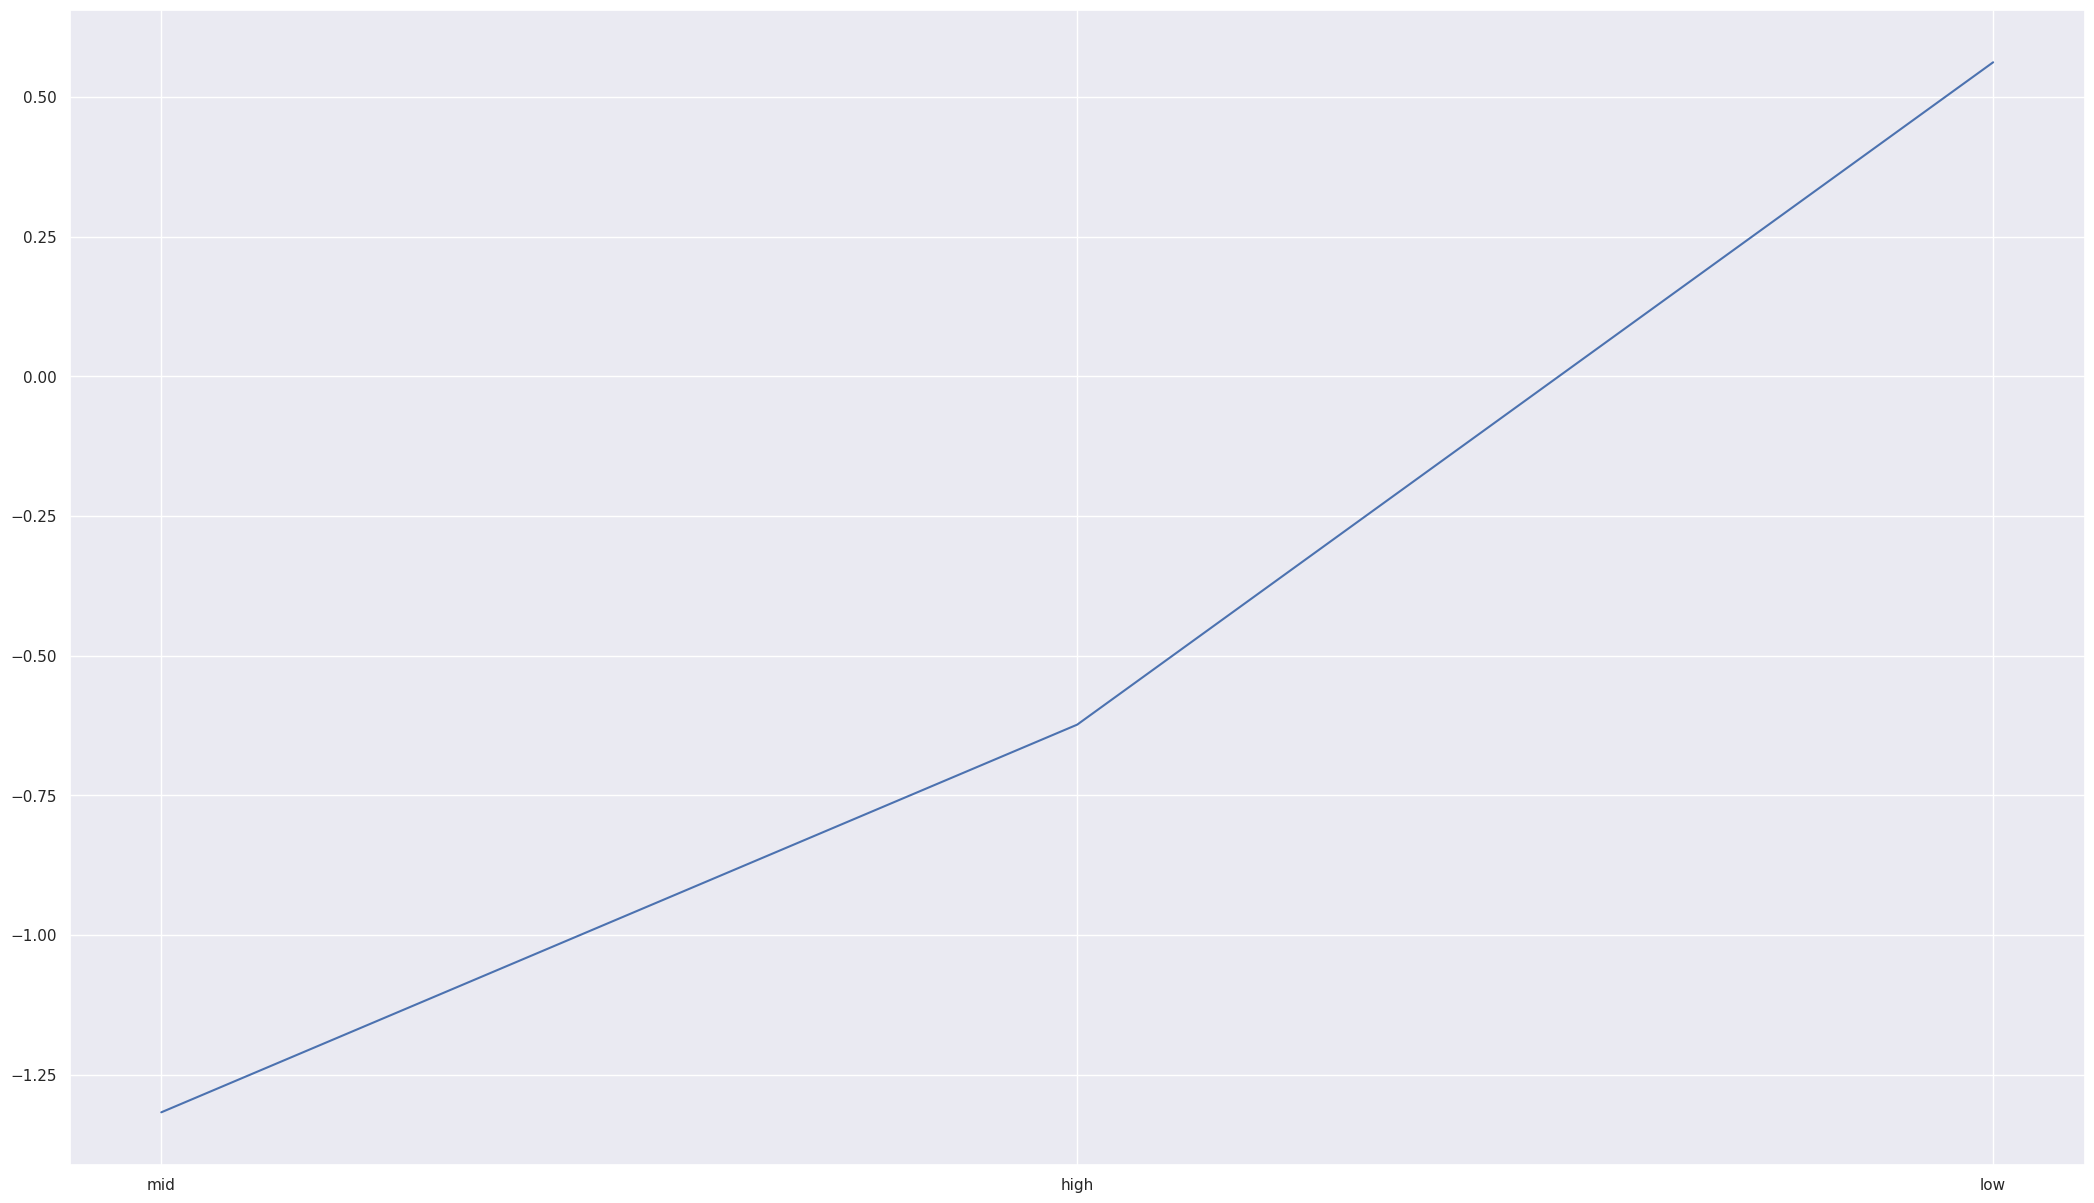

In [15]:
from numpy import average, mean

losses = [betting_slip.loss for betting_slip in fund_history_summary.betting_slips.values()]
payouts = [betting_slip.payout_percentage for betting_slip in fund_history_summary.betting_slips.values()]

print(f"bet rate: {fund_history_summary.bet_rate}")
print(f"max losses: {max(losses)}")
print(f"min:{min(payouts)}")
print(f"max:{max(payouts)}")
print(f"avg:{average(payouts)}")

payout_bet_count_dist = {}
payout_n_horses_dist = {}

for betting_slip in fund_history_summary.betting_slips.values():
    odds = 0
    if betting_slip.bets:
        for bet in betting_slip.bets:
            if bet.stakes_fraction > 0:
                odds = bet.odds

                odds_category = "low"
                if 2 <= odds <= 4:
                    odds_category = "mid"
                if 4 < odds:
                    odds_category = "high"
                if odds_category not in payout_bet_count_dist:
                    payout_bet_count_dist[odds_category] = {"total": bet.win - bet.loss, "n": 1}
                else:
                    payout_bet_count_dist[odds_category]["total"] += bet.win - bet.loss
                    payout_bet_count_dist[odds_category]["n"] += 1

        n_horses_category = len(betting_slip.bets)

        if n_horses_category not in payout_n_horses_dist:
            payout_n_horses_dist[n_horses_category] = 0

        payout_n_horses_dist[n_horses_category] += betting_slip.payout_percentage

for key in payout_bet_count_dist:
    if "total" in payout_bet_count_dist[key]:
        print(f"{key} count: {payout_bet_count_dist[key]['n']}")
        payout_bet_count_dist[key] = payout_bet_count_dist[key]["total"]

print(payout_bet_count_dist)
ax = sns.lineplot(data=payout_bet_count_dist)

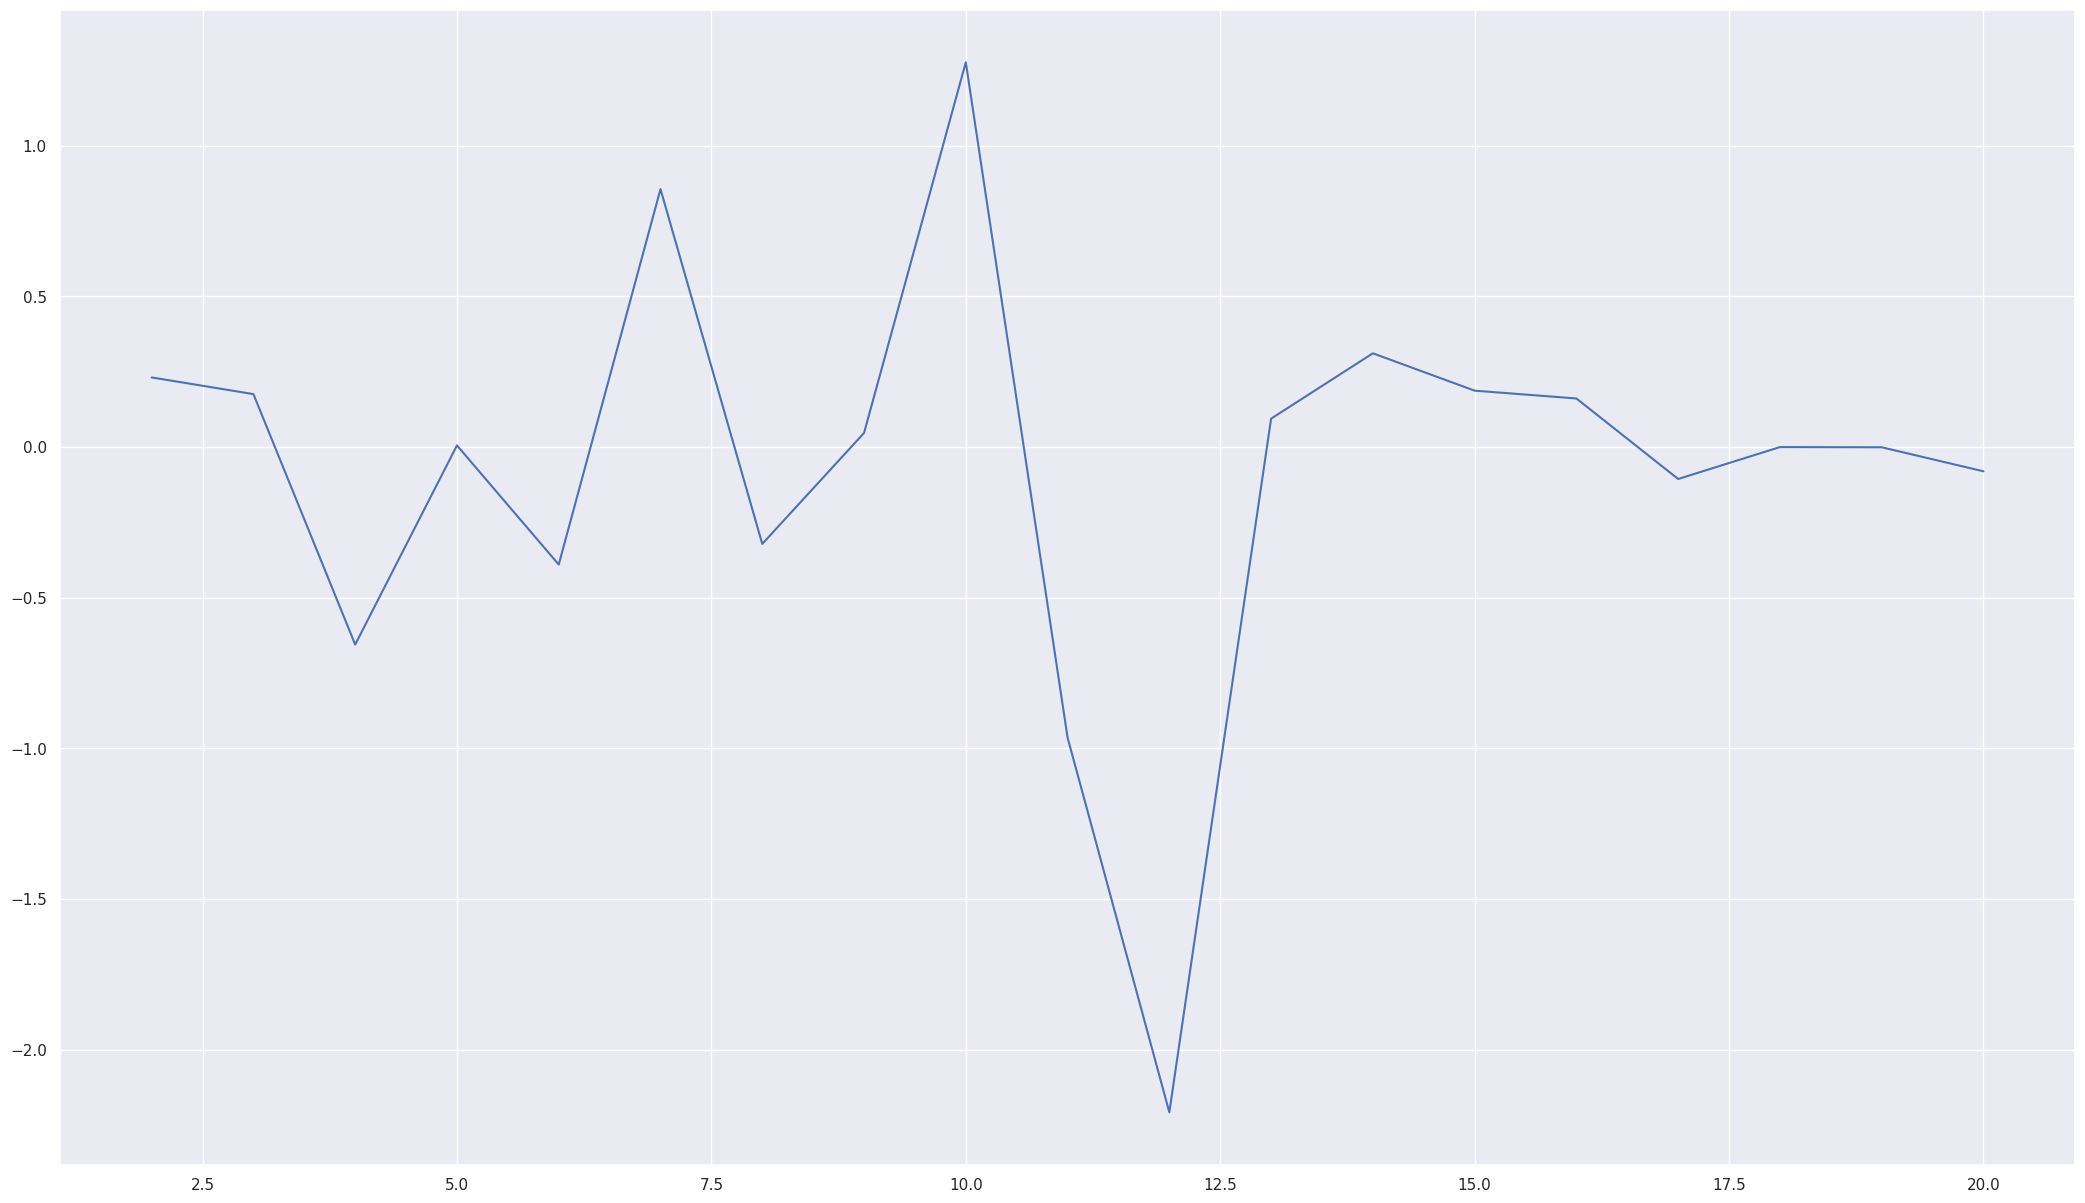

In [16]:
ax2 = sns.lineplot(data=payout_n_horses_dist)

In [18]:
sorted_betting_slips = sorted(fund_history_summary.betting_slips.values(), key=lambda x: x.payout_percentage, reverse=True)

for betting_slip in sorted_betting_slips:
    if betting_slip.race_id == 5377715:
        print(betting_slip)

worst_betting_slips = sorted_betting_slips[-1:]

for betting_slip in worst_betting_slips:
    print(betting_slip)
    print(f"https://www.racebets.de/de/pferdewetten/race/details/id/{betting_slip.race_id}/")

Betting slip:
(Fractional) total loss: 0.40205780052305334
Bets:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Win bet:
---------------------------------------
Horse number: 3
Odds of horse: 13.5
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.022303406551620455
---------------------------------------
Win bet:
---------------------------------------
Horse number: 12
Odds of horse: 42.0
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.019949800366359315
---------------------------------------
Win bet:
---------------------------------------
Horse number: 11
Odds of horse: 12.51
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.04289678707224094
---------------------------------------
Win bet:
---------------------------------------
Horse number: 10
Odds of horse: 42.0
(Fractional) stakes: 0.0
Potential win: 0.0
Estimated success probability: 0.011537181551187211
---------------------------------------


<AxesSubplot:>

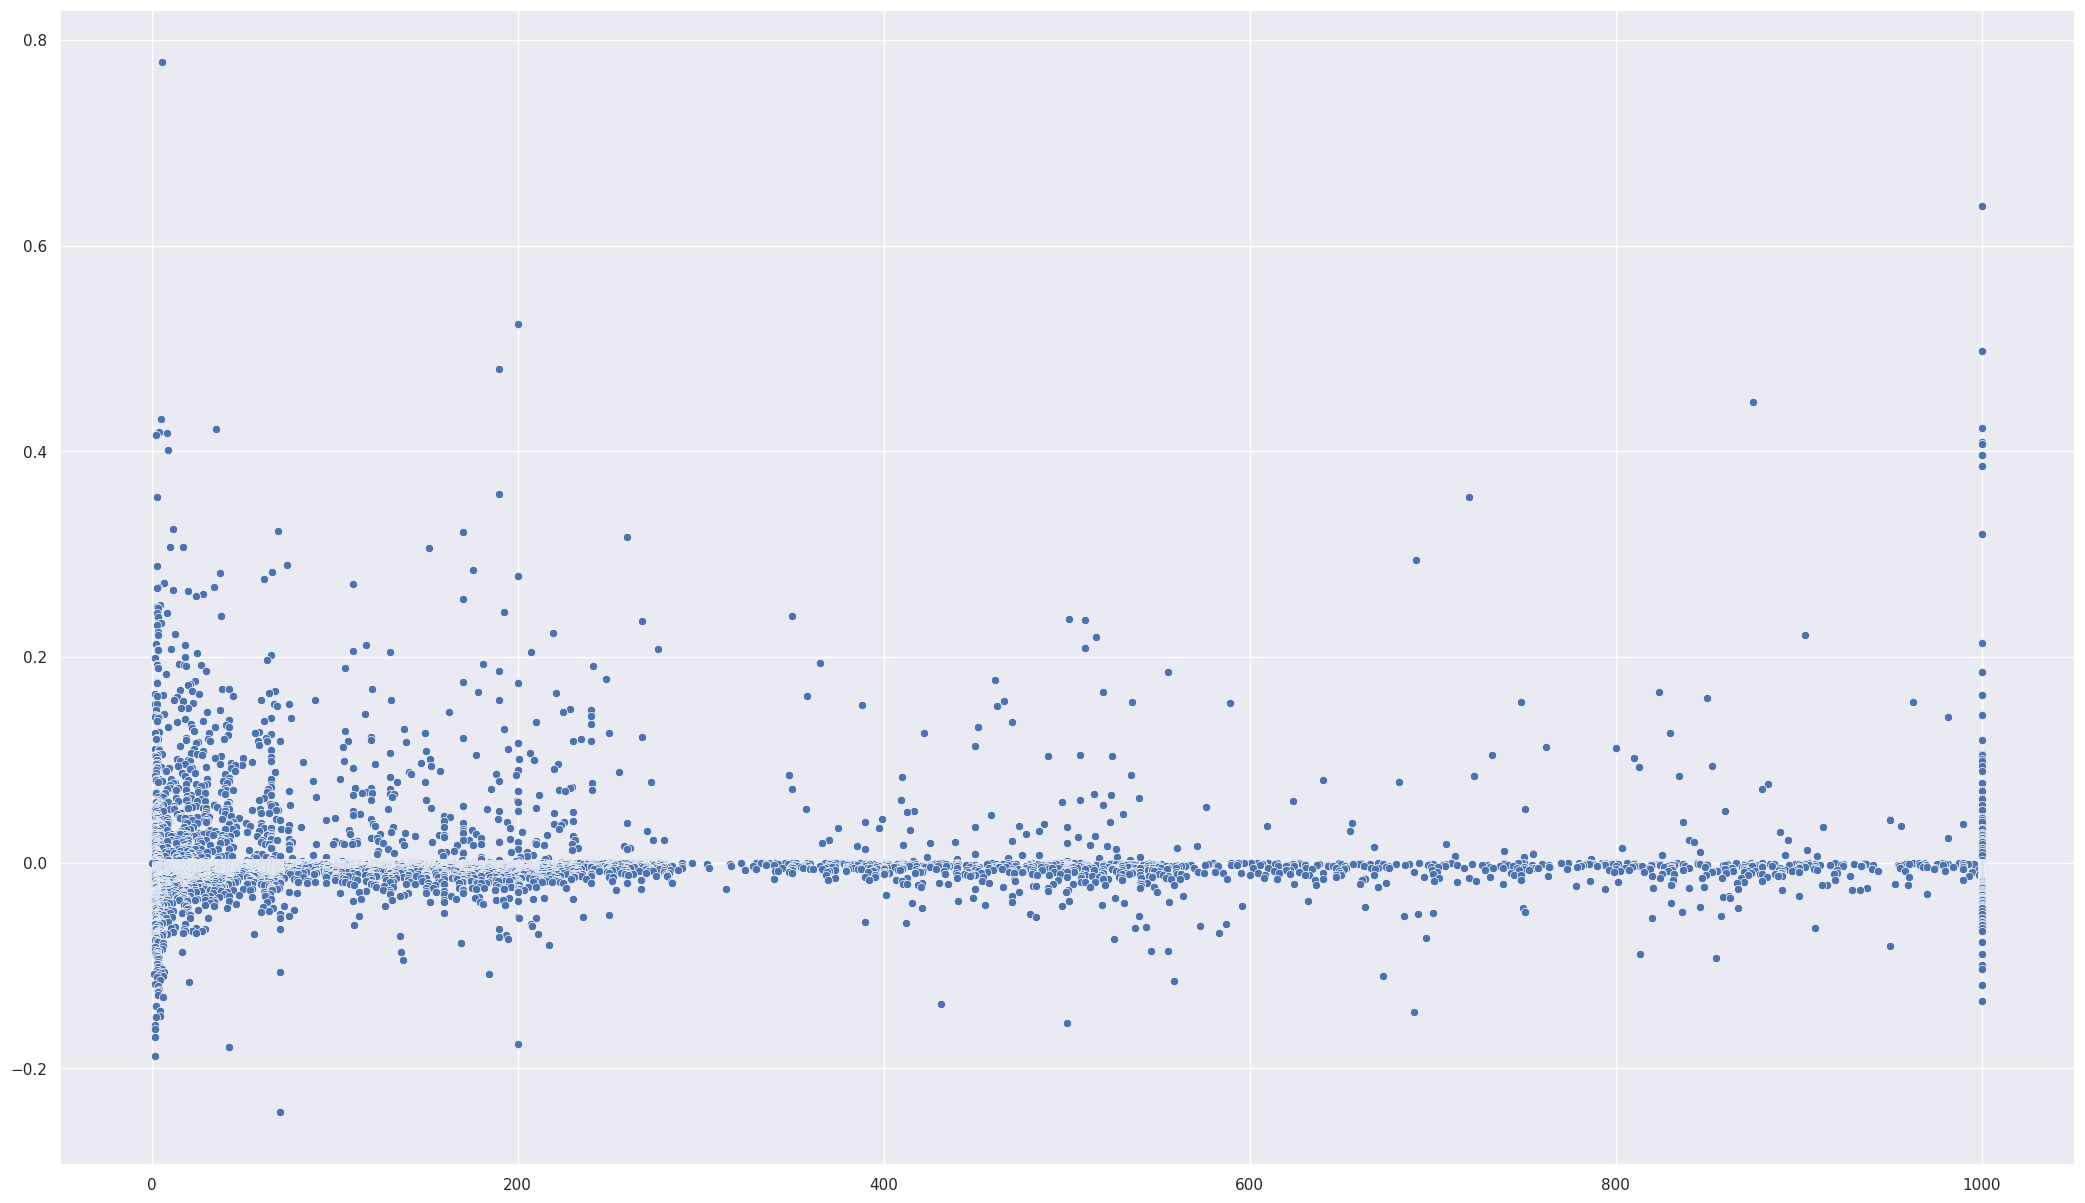

In [24]:
payout_percentages = [betting_slip.payout_percentage for betting_slip in sorted_betting_slips]
odds = []
for betting_slip in sorted_betting_slips:
    if betting_slip.bets:
        odds.append(betting_slip.bets[0].predicted_horse_results[0].betting_odds)
    else:
        odds.append(0)

sns.scatterplot(x=odds, y=payout_percentages)

## Real payout plotting

12.333333333333343


Text(0, 0.5, 'Wealth change in %')

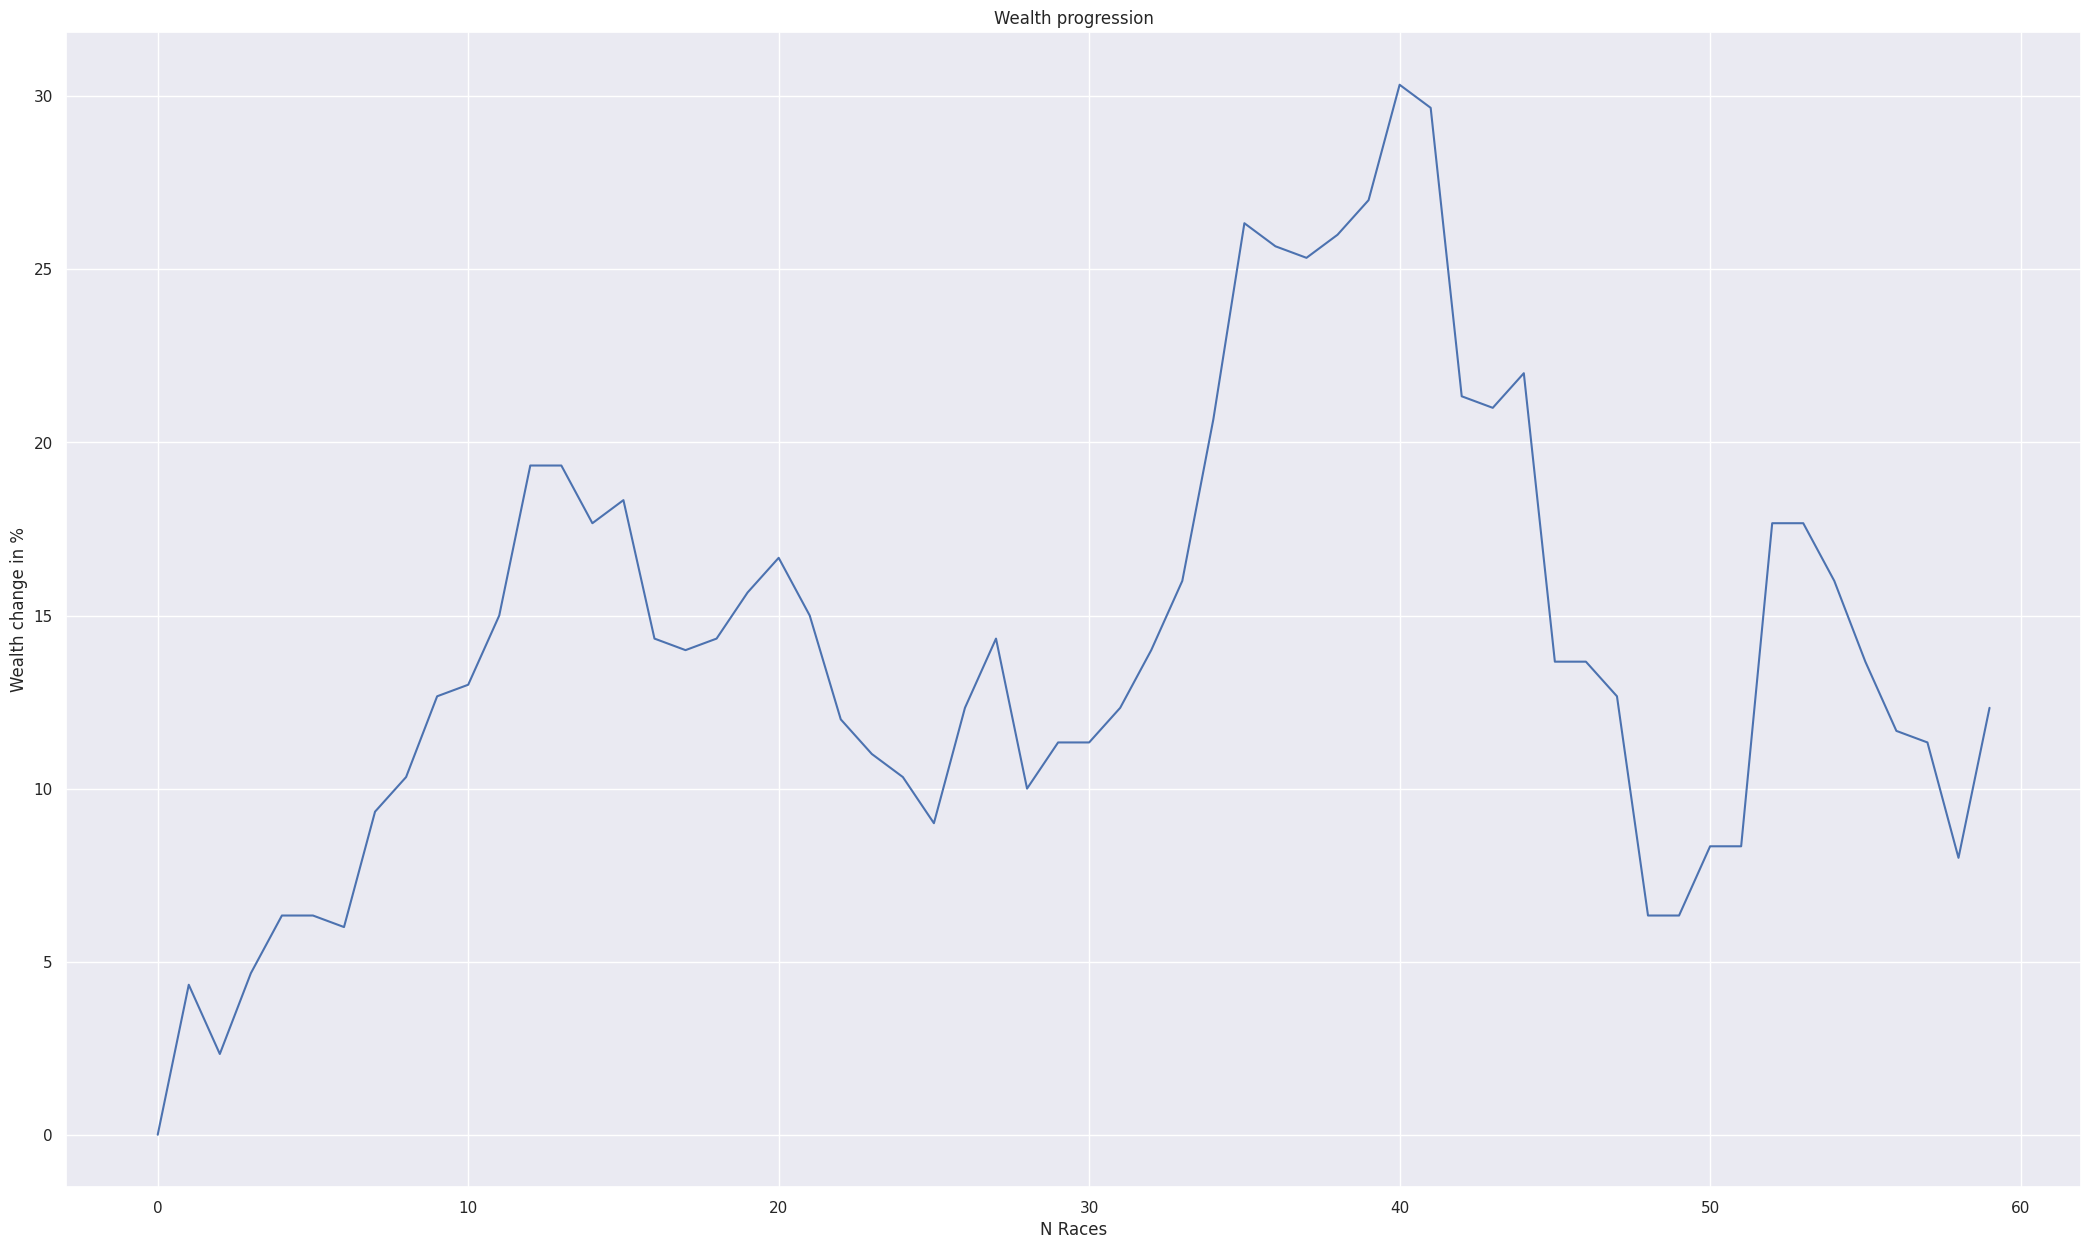

In [25]:
from numpy import cumsum
import seaborn as sns
real_payouts = [
    0, 13, -6, 7, 5, 0, -1, 10, 3, 7, 1, 6, 13, 0, -5, 2, -12,
    -1, 1,
    4, 3, -5, -9, -3, -2, -4, 10, 6, -13, 4, 0, 3,
    5, 6, 14, 17, -2, -1, 2, 3, 10, -2,
    -25, -1, 3, -25, 0, -3, -19, 0, 6, 0, 28, 0, -5, -7, -6, -1, -10, 13,
]

real_payouts = [real_payout / 3 for real_payout in real_payouts]

print(cumsum(real_payouts)[-1])

ax = sns.lineplot(cumsum(real_payouts))
ax.set_title("Wealth progression")
ax.set_xlabel("N Races")
ax.set_ylabel("Wealth change in %")

In [10]:
import pandas as pd

# Create a sample dataframe with three columns 'A', 'B', and 'C'
df = pd.DataFrame({'A': [1, 1, 1, 2, 2, 2, 2, 2],
                   'B': [2, 3, 5, 10, 20, 55, 65, 75],
                   'C': [2, 2, 2, 3, 3, 3, 3, 3]})

# Group the dataframe by column 'A' and get the values of 'B' and 'C' for each group
grouped = df.groupby('A')[['B', 'C']].agg({'B': lambda x: list(x), 'C': 'first'})

# Convert the grouped values to a list of tuples
result = [tuple(row) for row in grouped.values]

print(result)

[([2, 3, 5], 2), ([10, 20, 55, 65, 75], 3)]


In [29]:
import pickle

BET_MODEL_CONFIGURATION_PATH = "../data/bet_model_configuration.dat"

with open(BET_MODEL_CONFIGURATION_PATH, "rb") as f:
    bet_model_configuration = pickle.load(f)

print([feature.get_name() for feature in bet_model_configuration.feature_subset])

['BetfairWinMarketWinProbability', 'PreviousRelativeDistanceBehind', 'PreviousSlowerThanNumber', 'IndustryMarketWinProbabilityDiff', 'CurrentSpeedFigure', 'Gender', 'MinutesIntoDay', 'CurrentDistance', 'HasFallen', 'HasTrackChanged', 'HasTrainerMultipleHorses', 'WeekDayCos', 'CurrentRaceClass', 'CurrentGoing', 'CurrentRaceType', 'CurrentRaceCategory', 'AgeFrom', 'HasBlinkers', 'HasVisor', 'HasHood', 'HasCheekPieces', 'HasEyeCovers', 'HasTongueStrap', 'AbsoluteTime', 'TwoYearStartCount', 'HasFewStartsInTwoYears', 'JockeyWinRate', 'BreederWinRate', 'DamSireWinRate', 'HorseTrainerWinRate', 'JockeyTrackWinRate', 'JockeyClassWinRate', 'TrainerSurfaceWinRate', 'TrainerTrackWinRate', 'HorseShowRate', 'SireShowRate', 'DamSireShowRate', 'HorseBreederShowRate', 'JockeyTrackShowRate', 'TrainerSurfaceShowRate', 'TrainerTrackShowRate', 'HorsePurseRate', 'JockeyPurseRate', 'OwnerPurseRate', 'DamPurseRate', 'DamSirePurseRate', 'HorseJockeyPurseRate', 'HorseBreederPurseRate', 'JockeyDistancePurseRate'

100